Хакатон DANO 18-19 мая 2024

День 1

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from copy import deepcopy

In [46]:
path = 'data.csv'
DF_const = pd.read_csv(path)

In [47]:
df = deepcopy(DF_const)
# Нас интересуют лишь одобренные кредиты
df = df[df['success_activate_flg'] == 1]
print(f"Количество одобренных кредитов: {df.shape[0]}")

Количество одобренных кредитов: 47690


In [48]:
# -1 - пол неизвестен
# # 0 - мужчины
# 1 - женщины
df.loc[:, 'gender_code'] = df['gender_code'].fillna('U').map({'M': 0, 'F': 1, 'U': -1}).astype("Int64")

In [49]:
print(f"Количество кредитов, одобренных мужчинам: {df[df['gender_code'] == 0].shape[0]}")
print(f"Количество кредитов, одобренных женщинам: {df[df['gender_code'] == 1].shape[0]}")
if df[df['gender_code'] == -1].shape[0]:
    print(f"Количество кредитов, одобренных людям, пол которых неизвестен: {df[df['gender_code'] == -1].shape[0]}")

Количество кредитов, одобренных мужчинам: 29961
Количество кредитов, одобренных женщинам: 17727
Количество кредитов, одобренных людям, пол которых неизвестен: 2


In [50]:
# Удалим людей, пол которых неизвестен
df = df[df['gender_code'] != -1]

In [51]:
# Процент значений, которые считаем выбросами
p = 5

In [52]:
percent = p / 100
print(f"Исходный размер: {df.shape[0]}")

# Удаляем выбросы по параметру 'monthly_income_rate' (месячный доход)
del_array = ['monthly_income_amt']
for nf in del_array:
    df_low = 0
    df_high = df[nf].quantile(1 - percent)
    df = df[(df[nf] > df_low) & (df[nf] < df_high)]
print(f"Конечный размер: {df.shape[0]}")

Исходный размер: 47688
Конечный размер: 43808


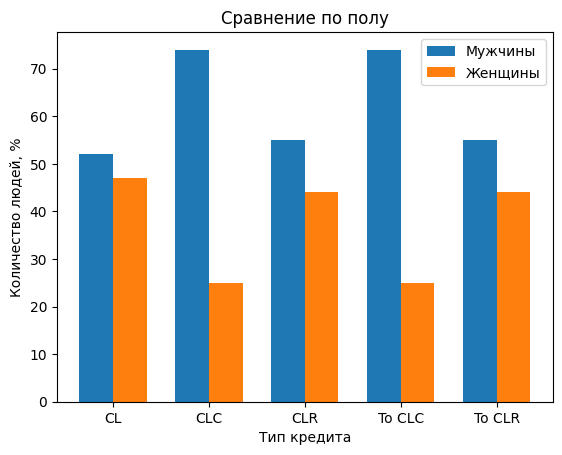

In [53]:
# Keys - типы кредита
Keys = sorted(list(set(df['agreement_product_code'].values)))
res = {0: [], 1: []}

for k in Keys:
    # Доля мужчин среди тех, кому одобрен кредит типа k
    res[0].append(int(100 * 
                      df[(df['gender_code'] == 0) & (df['agreement_product_code'] == k)].shape[0] / 
                      df[df['agreement_product_code'] == k].shape[0]))
    # Доля женщин среди тех, кому одобрен кредит типа k
    res[1].append(int(100 * 
                      df[(df['gender_code'] == 1) & (df['agreement_product_code'] == k)].shape[0] / 
                      df[df['agreement_product_code'] == k].shape[0]))

# Построение диаграммы
bar_width = 0.35
index = np.arange(len(Keys))
plt.bar(index, res[0], bar_width, label='Мужчины')
plt.bar(index + bar_width, res[1], bar_width, label='Женщины')
plt.xlabel('Тип кредита')
plt.ylabel('Количество людей, %')
plt.title('Сравнение по полу')
plt.xticks(index + bar_width / 2, Keys)
plt.legend()


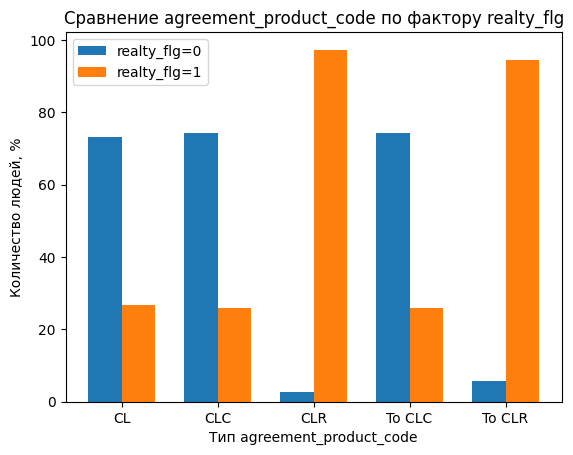

In [54]:
# Построение диаграммы, отражающей процент людей с конкретным значением фактора X
# (в данном случае для X = 'realty_flg' - 0 или 1) среди людей с конкретным значением
# фактора Y (в данном случае для 'agreement_product_code' - 'CL', 'CLC', 'CLR', 'To CLC', 'To CLR')

X = 'realty_flg'
Y = 'agreement_product_code'
vx = sorted(list(set(df[X].values)))

D = dict(df[Y].value_counts())
Keys = sorted(D.keys())
res = [[] for i in range(len(vx))]

for ind in range(len(Keys)):
    k = Keys[ind]
    for i in range(len(vx)):
        res[i].append(100 * df[((df[X] == vx[i]) & (df[Y] == k))].shape[0] / D[k])
bar_width = 0.35
index = np.arange(len(res[0]))
for i in range(len(vx)):
    plt.bar(index + i * bar_width, res[i], bar_width, label=f"{X}={vx[i]}")
plt.xlabel(f'Тип {Y}')
plt.ylabel(f'Количество людей, %')
plt.title(f'Сравнение {Y} по фактору {X}')
plt.xticks(index + bar_width / 2, Keys)
plt.legend()



In [55]:
# Количество людей, которые запрашивали продукт Requst продукт Res 
# (в абсолютных числах и в процентах от общего количества обратившихся за конкретным Request)

a = ['Request\tRes\tNum\t% from request\n']
for req in sorted(set(df['req_product_code'].values)):
    a.append('-' * 40 + '\n')
    L = df[(df['req_product_code'] == req)].shape[0]
    for agr in sorted(set(df['agreement_product_code'].values)):
        num = df[(df['req_product_code'] == req) & (df['agreement_product_code'] == agr)].shape[0]
        if num:
            a.append(f'{req}\t{agr}\t{num}\t{int(100 * num / L)}\n')
print(''.join(a))

Request	Res	Num	% from request
----------------------------------------
CL	CL	22585	51
CL	CLC	9390	21
CL	CLR	1109	2
CL	To CLC	9426	21
CL	To CLR	1172	2
----------------------------------------
CLC	CL	2	1
CLC	CLC	119	98
----------------------------------------
CLR	CLR	2	40
CLR	To CLC	3	60



In [56]:
print(f"""{df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) & (df['realty_flg'] == 0)].shape[0]
         } людей без недвижимости получили одобренный кредит под залог недвижимости ('CLR' или 'To CLR')""")
print(f"""{df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) & (df['car_flg'] == 0)].shape[0]
         } людей без машины получили одобренный кредит под залог автомобиля ('CLC' или 'To CLC')""")

96 людей без недвижимости получили одобренный кредит под залог недвижимости ('CLR' или 'To CLR')
4005 людей без машины получили одобренный кредит под залог автомобиля ('CLC' или 'To CLC')


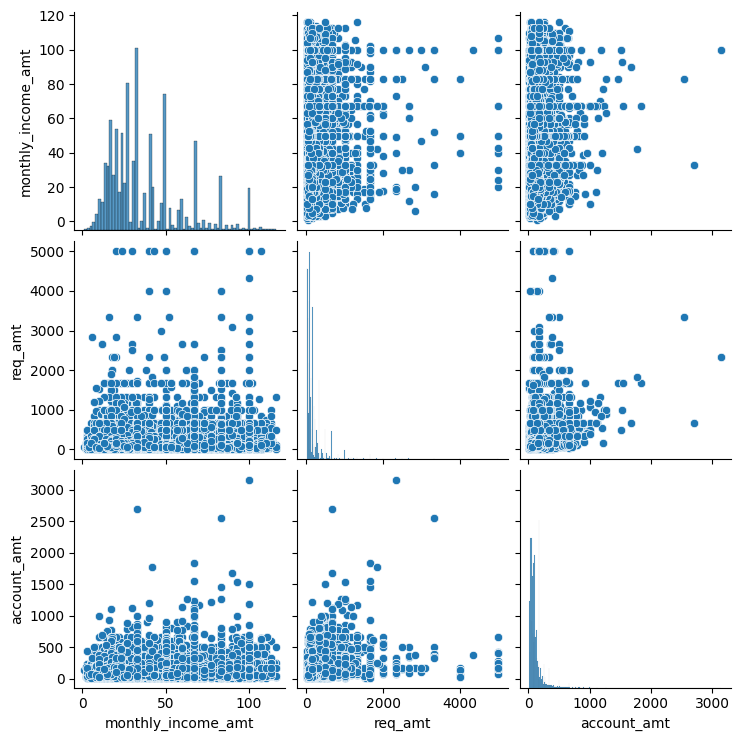

In [57]:
# Поиск зависимостей между доходом (в месяц), запрошенной суммой и согласованной суммой

sns.pairplot(df[['monthly_income_amt', 'req_amt', 'account_amt']])

<Axes: xlabel='monthly_income_amt', ylabel='account_amt'>

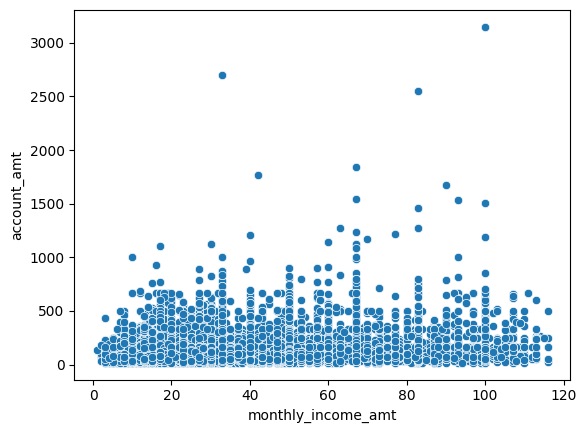

In [58]:
# График зависимости между доходом (в месяц) и согласованной суммой

sns.scatterplot(data=df, x='monthly_income_amt', y='account_amt')

In [59]:
# Функция подсчёта корелляции между xs и ys

def corr(xs, ys):
    x = np.array(xs)
    y = np.array(ys)
    xm = x.mean()
    ym = y.mean()
    S = np.sum((x - xm) * (y - ym))
    S1 = np.sum((x - xm) * (x - xm))
    S2 = np.sum((y - ym) * (y - ym))
    return S / (S1 * S2) ** 0.5


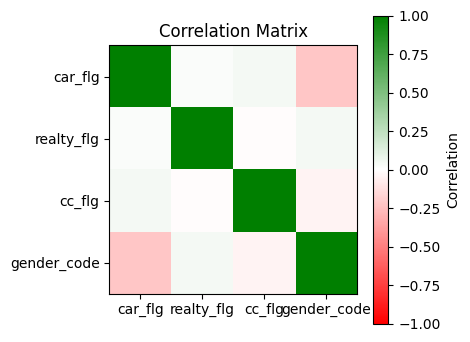

In [60]:
# Значения для поиска корелляции (бинарные признаки)
val = ['car_flg', 'realty_flg', 'cc_flg', 'gender_code']

# Берем только известные значения
df_clear = df.dropna(subset=val)

a = np.array([[corr(np.array(df_clear[val[i]]), np.array(df_clear[val[j]])) for j in range(len(val))] for i in range(len(val))])

# Построение матрицы корелляций
plt.figure(figsize=(len(val), len(val)))
plt.imshow(a, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) , interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(range(len(a)), val)
plt.yticks(range(len(a)), val)
plt.grid(False)
plt.show()

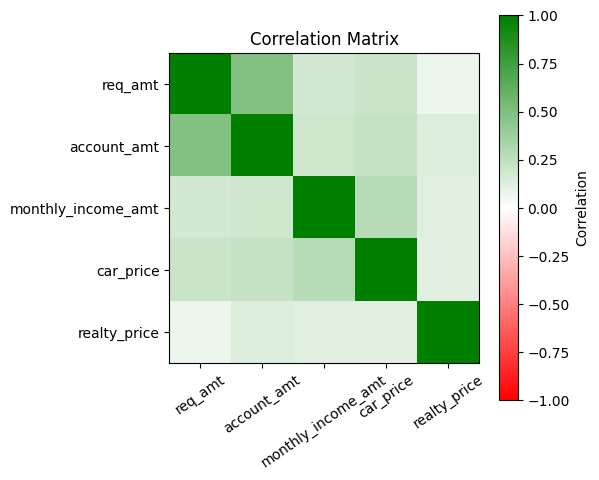

In [61]:
# Значения для поиска корелляции (числовые признаки)
val = ['req_amt', 'account_amt', 'monthly_income_amt', 'car_price', 'realty_price']

# Берем только известные значения
df_clear = df.dropna(subset=val)

a = np.array([[corr(np.array(df_clear[val[i]]), np.array(df_clear[val[j]])) for j in range(len(val))] for i in range(len(val))])

# Построение матрицы корелляций
plt.figure(figsize=(len(val), len(val)))
plt.imshow(a, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) , interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(range(len(a)), val, rotation=35)
plt.yticks(range(len(a)), val)
plt.grid(False)
plt.show()

День 2

In [62]:
def rd(x):
    return round(x, 2)

In [63]:
# На этот раз будем анализировать все кредиты (в т.ч. неодобренные)
df = deepcopy(DF_const)
# Анализируем количество кредитов для возрастов от 14 лет
df = df[df["age"] >= 14]
print(f"Количество всех кредитов: {df.shape[0]}")

Количество всех кредитов: 225947


In [64]:
important_values = ['req_product_code', 'agreement_product_code']
categorical_features = ['gender_code', 'car_flg', 'realty_flg', 'cc_flg']
numerical_features = ['monthly_income_amt', 'car_price', 'realty_price']

In [65]:
# Dist - файл для записи распределения значений
# Распределение значений категориальных признаков:
Dist = open('Dist.txt', mode='w')
print('Categorial Features:\n', file=Dist)
CF = {}
for cf in categorical_features:
    print(cf, file=Dist)
    CF[cf] = {}
    for key in set(df[cf].values):
        CF[cf][key] = df[df[cf] == key].shape[0]
    for key, val in CF[cf].items():
        if val:
            print(key, val, file=Dist)
    print(file=Dist)
print(file=Dist)
Dist.close()

In [66]:
# N - количество блоков, на которые мы разбиваем числовые признаки
N = 25

In [67]:
Dist = open('Dist.txt', mode='a')
print('Numerical Features:\n', file=Dist)
NF = {}
for nf in numerical_features:
    print(nf, file=Dist)
    NF[nf] = {}
    Min = df[nf].min()
    Max = df[nf].max()
    w = (Max - Min) / N
    for i in range(N):
        key = f'[{rd(Min + i * w)}; {rd(Min + (i + 1) * w)})'
        val = df[(df[nf] >= Min + i * w) & (df[nf] < Min + (i + 1) * w)].shape[0]
        NF[nf][key] = val
    for key, val in NF[nf].items():
        if val:
            print(key, val, file=Dist)
    print(file=Dist)
print(file=Dist)
Dist.close()

Text(0.5, 1.0, 'agreement_product_code')

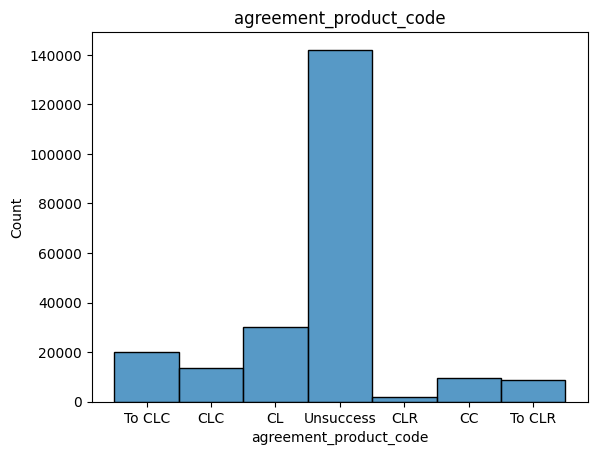

In [68]:
# Распределение выданных продуктов
sns.histplot(df['agreement_product_code'])
plt.title('agreement_product_code')

Text(0.5, 1.0, 'agreement_product_code without Unsuccess')

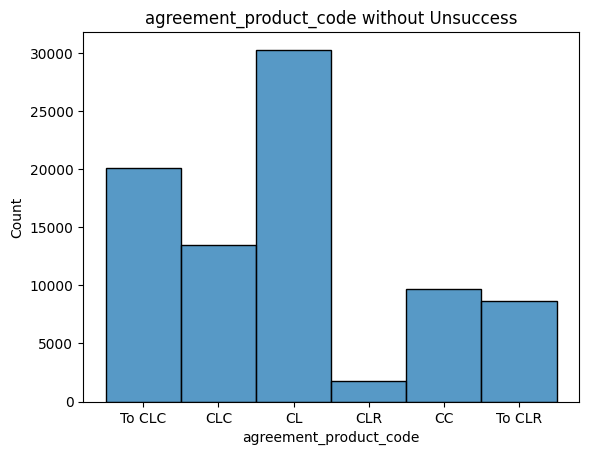

In [69]:
# Распределение выданных продуктов (без учёта отказов)
sns.histplot(df[df['agreement_product_code'] != 'Unsuccess']['agreement_product_code'])
plt.title('agreement_product_code without Unsuccess')

Text(0.5, 1.0, 'agreement_product_code successful, people with car')

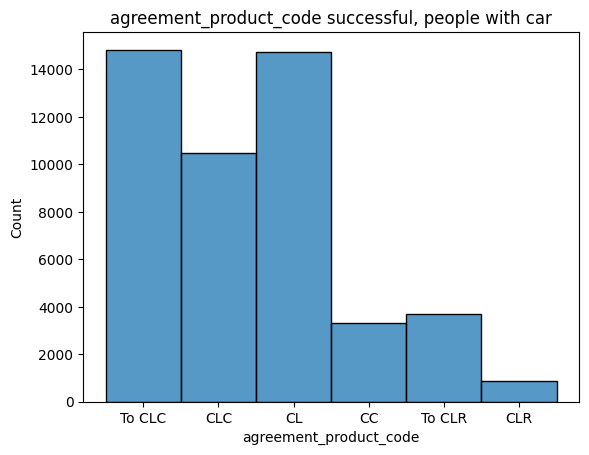

In [70]:
# Распределение выданных продуктов людям с машиной (без учёта отказов)
sns.histplot(df[(df['car_flg'] == 1) & (df['agreement_product_code'] != 'Unsuccess')]['agreement_product_code'])
plt.title('agreement_product_code successful, people with car')

Text(0.5, 1.0, 'agreement_product_code successful, people with realty')

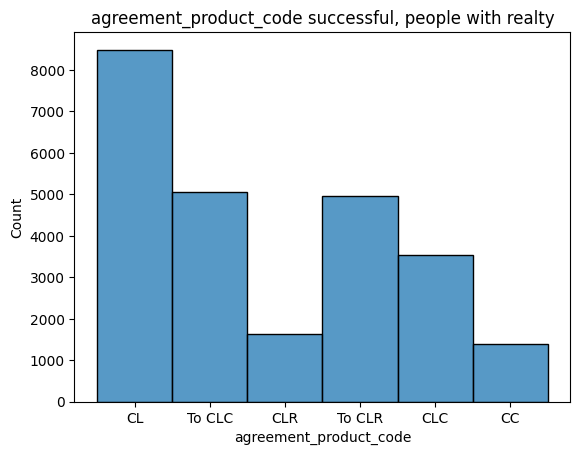

In [71]:
# Распределение выданных продуктов людям с недвижимостью (без учёта отказов)
sns.histplot(df[(df['realty_flg'] == 1) & (df['agreement_product_code'] != 'Unsuccess')]['agreement_product_code'])
plt.title('agreement_product_code successful, people with realty')

Text(0.5, 1.0, 'Age distribution, agreement_product_code = CL')

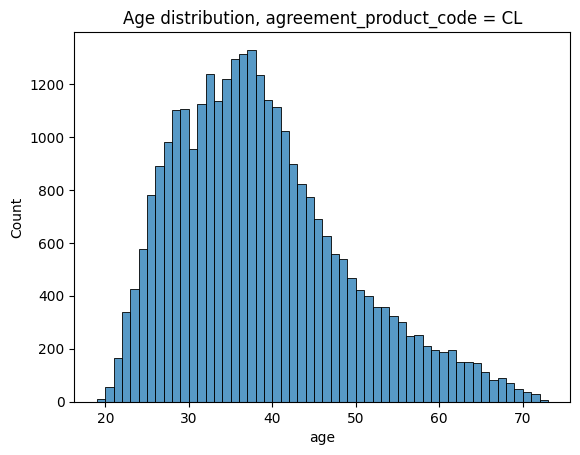

In [72]:
# Распределение по возрасту людей, которым одобрен кредит наличными
sns.histplot(df[(df['agreement_product_code'] == 'CL')]['age'], binwidth=1)
plt.title('Age distribution, agreement_product_code = CL')

Text(0.5, 1.0, 'Age distribution, agreement_product_code = CLR')

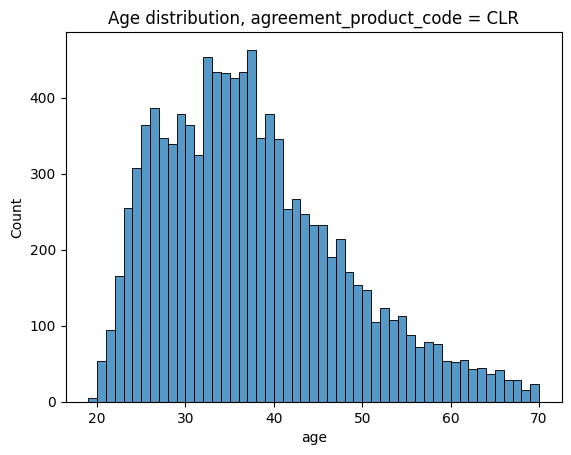

In [73]:
# Распределение по возрасту людей, которым одобрен кредит наличными под залог недвижимости
sns.histplot(df[(df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')]['age'], binwidth=1)
plt.title('Age distribution, agreement_product_code = CLR')

Text(0.5, 1.0, 'Age distribution, agreement_product_code = CLC')

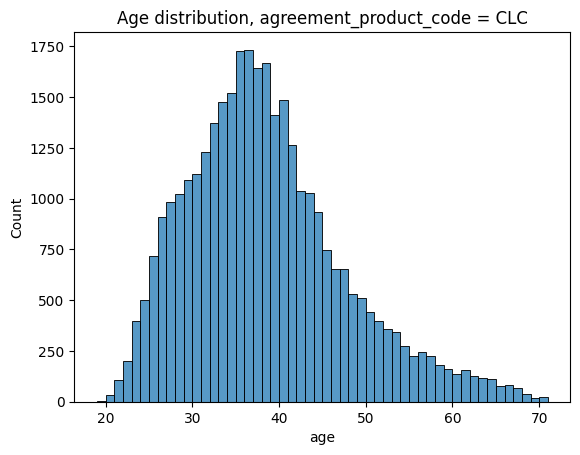

In [74]:
# Распределение по возрасту людей, которым одобрен кредит наличными под залог автомобиля
sns.histplot(df[(df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')]['age'], binwidth=1)
plt.title('Age distribution, agreement_product_code = CLC')

Text(0.5, 1.0, 'monthly_income_amt distribution, agreement_product_code = CL')

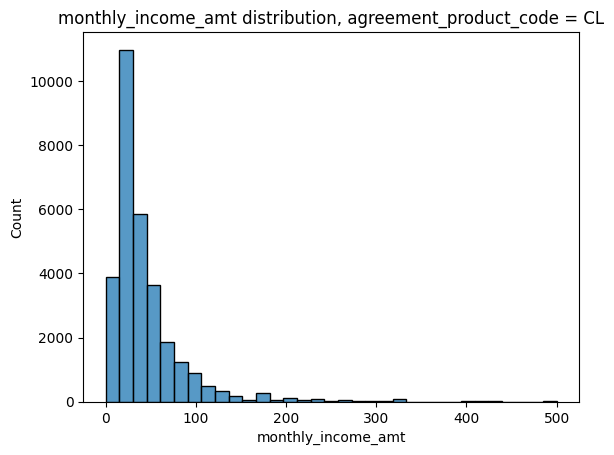

In [75]:
# Распределение по месячному доходу людей, которым одобрен кредит наличными
# (без учёта людей с доходом > 500)
sns.histplot(df[(df['agreement_product_code'] == 'CL') & (df['monthly_income_amt'] <= 500)]['monthly_income_amt'], binwidth=15)
plt.title('monthly_income_amt distribution, agreement_product_code = CL')

Text(0.5, 1.0, 'monthly_income_amt distribution, agreement_product_code = CLR')

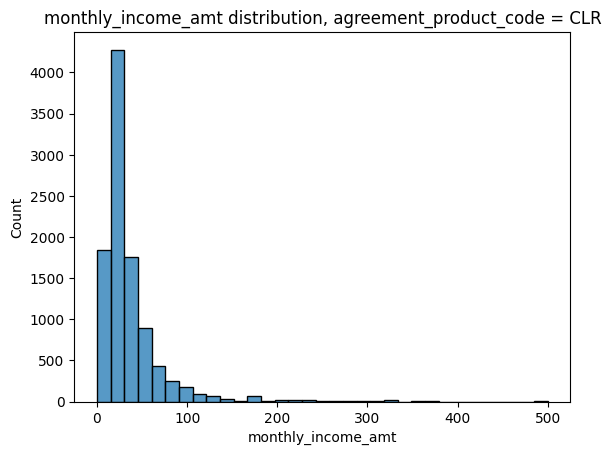

In [76]:
# Распределение по месячному доходу людей, которым одобрен кредит наличными под залог недвижимости
# (без учёта людей с доходом > 500)
sns.histplot(df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) &
                (df['monthly_income_amt'] <= 500)]['monthly_income_amt'], binwidth=15)
plt.title('monthly_income_amt distribution, agreement_product_code = CLR')

Text(0.5, 1.0, 'monthly_income_amt distribution, agreement_product_code = CLC')

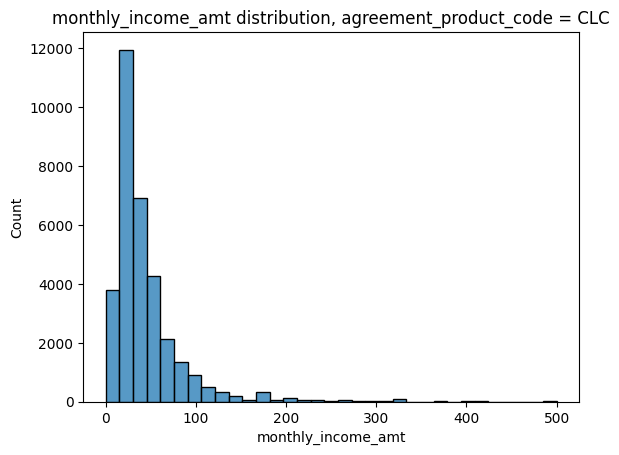

In [77]:
# Распределение по месячному доходу людей, которым одобрен кредит наличными под залог автомобиля
sns.histplot(df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) &
                (df['monthly_income_amt'] <= 500)]['monthly_income_amt'], binwidth=15)
plt.title('monthly_income_amt distribution, agreement_product_code = CLC')

Text(0.5, 1.0, 'Процент тех, кому одобрили CL среди тех, кому одобрили хоть что-то')

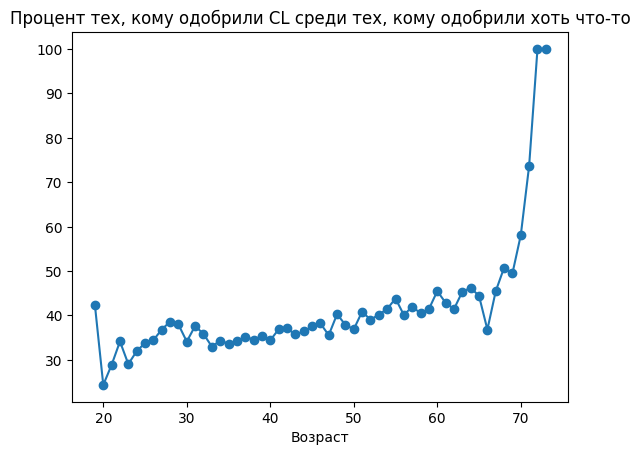

In [78]:
# Ищем процент тех, кому одобрили кредит наличными среди людей, которым одобрили какой-либо продукт
test = df[(df['agreement_product_code'] != 'Unsuccess')].groupby('age')
test_new = df[(df['agreement_product_code'] == 'CL')].groupby('age')
MyData = {}
MyDataNew = {'age': [], 'proc': []}
for age, data in test:
    MyData[age] = data.shape[0]
for age, data in test_new:
    MyDataNew['age'].append(age)
    MyDataNew['proc'].append(data.shape[0])
for i in range(len(MyDataNew['age'])):
    MyDataNew['proc'][i] = 100 * MyDataNew['proc'][i] / MyData[MyDataNew['age'][i]]
MyDataNew = pd.DataFrame(MyDataNew)
plt.plot(MyDataNew['age'], MyDataNew['proc'], linestyle='-', marker='o')
plt.xlabel('Возраст')
plt.title('Процент тех, кому одобрили CL среди тех, кому одобрили хоть что-то')

Text(0.5, 1.0, 'Процент тех, кому одобрили CLС среди тех, кому одобрили хоть что-то')

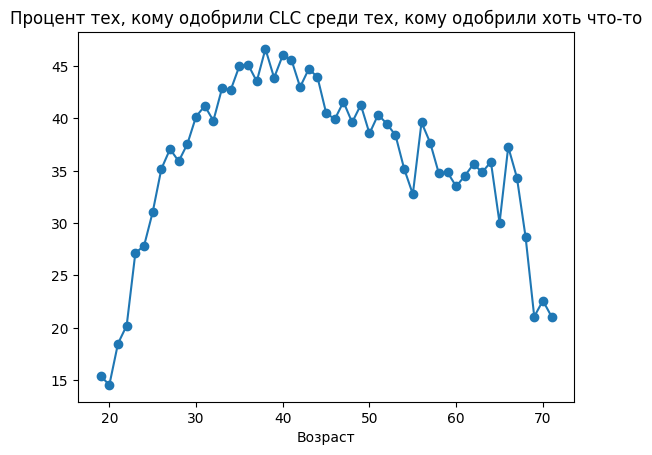

In [79]:
# Ищем процент тех, кому одобрили кредит наличными под залог автомобиля среди людей, которым одобрили какой-либо продукт
test = df[(df['agreement_product_code'] != 'Unsuccess')].groupby('age')
test_new = df[(df['agreement_product_code'] == 'To CLC') | (df['agreement_product_code'] == 'CLC')].groupby('age')
MyData = {}
MyDataNew = {'age': [], 'proc': []}
for age, data in test:
    MyData[age] = data.shape[0]
for age, data in test_new:
    MyDataNew['age'].append(age)
    MyDataNew['proc'].append(data.shape[0])
for i in range(len(MyDataNew['age'])):
    MyDataNew['proc'][i] = 100 * MyDataNew['proc'][i] / MyData[MyDataNew['age'][i]]
MyDataNew = pd.DataFrame(MyDataNew)
plt.plot(MyDataNew['age'], MyDataNew['proc'], linestyle='-', marker='o')
plt.xlabel('Возраст')
plt.title('Процент тех, кому одобрили CLС среди тех, кому одобрили хоть что-то')

Text(0.5, 1.0, 'Процент тех, кому одобрили CLR среди тех, кому одобрили хоть что-то')

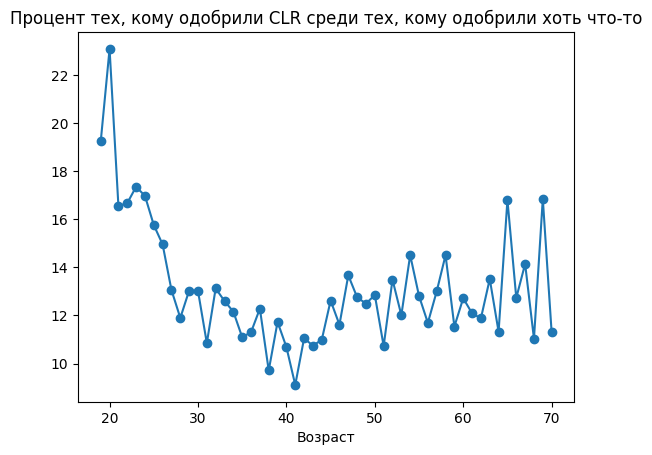

In [80]:
# Ищем процент тех, кому одобрили кредит наличными под залог недвижимости среди людей, которым одобрили какой-либо продукт
test = df[(df['agreement_product_code'] != 'Unsuccess')].groupby('age')
test_new = df[(df['agreement_product_code'] == 'To CLR') | (df['agreement_product_code'] == 'CLR')].groupby('age')
MyData = {}
MyDataNew = {'age': [], 'proc': []}
for age, data in test:
    MyData[age] = data.shape[0]
for age, data in test_new:
    MyDataNew['age'].append(age)
    MyDataNew['proc'].append(data.shape[0])
for i in range(len(MyDataNew['age'])):
    MyDataNew['proc'][i] = 100 * MyDataNew['proc'][i] / MyData[MyDataNew['age'][i]]
MyDataNew = pd.DataFrame(MyDataNew)
plt.plot(MyDataNew['age'], MyDataNew['proc'], linestyle='-', marker='o')
plt.xlabel('Возраст')
plt.title('Процент тех, кому одобрили CLR среди тех, кому одобрили хоть что-то')

Text(0.5, 1.0, 'Процент тех, кому одобрили CC среди тех, кому одобрили хоть что-то')

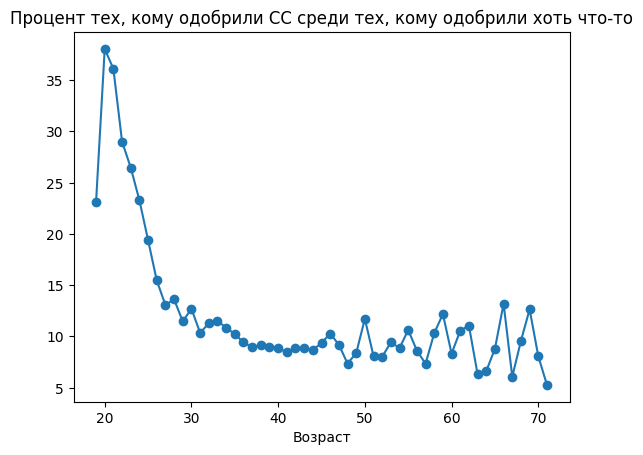

In [81]:
# Ищем процент тех, кому одобрили кредитные карты среди людей, которым одобрили какой-либо продукт
test = df[(df['agreement_product_code'] != 'Unsuccess')].groupby('age')
test_new = df[(df['agreement_product_code'] == 'CC')].groupby('age')
MyData = {}
MyDataNew = {'age': [], 'proc': []}
for age, data in test:
    MyData[age] = data.shape[0]
for age, data in test_new:
    MyDataNew['age'].append(age)
    MyDataNew['proc'].append(data.shape[0])
for i in range(len(MyDataNew['age'])):
    MyDataNew['proc'][i] = 100 * MyDataNew['proc'][i] / MyData[MyDataNew['age'][i]]
MyDataNew = pd.DataFrame(MyDataNew)
plt.plot(MyDataNew['age'], MyDataNew['proc'], linestyle='-', marker='o')
plt.xlabel('Возраст')
plt.title('Процент тех, кому одобрили CC среди тех, кому одобрили хоть что-то')


In [82]:
print(f"""Процент обладателей кредитных карт среди подавших заявку на кредит под залог автомобиля: {
    rd(100 * df[((df['req_product_code'] == 'CLC') | (df['req_product_code'] == 'To CLC')) & (df['cc_flg'] == 1)].shape[0] / 
       df[(df['req_product_code'] == 'CLC') | (df['req_product_code'] == 'To CLC')].shape[0])} %""")
print(f"""Процент обладателей кредитными картами среди подавших заявку на кредит под залог автомобиля: {
    rd(100 * df[((df['req_product_code'] == 'CLC') | (df['req_product_code'] == 'To CLC')) & (df['cc_flg'] == 0)].shape[0] / 
       df[(df['req_product_code'] == 'CLC') | (df['req_product_code'] == 'To CLC')].shape[0])} %""")

Процент обладателей кредитных карт среди подавших заявку на кредит под залог автомобиля: 73.23 %
Процент обладателей кредитными картами среди подавших заявку на кредит под залог автомобиля: 26.77 %


In [83]:
print(f"""Процент обладателей кредитных карт среди подавших заявку на кредит под залог недвижимости: {
    rd(100 * df[((df['req_product_code'] == 'CLR') | (df['req_product_code'] == 'To CLR')) & (df['cc_flg'] == 1)].shape[0] / 
       df[(df['req_product_code'] == 'CLR') | (df['req_product_code'] == 'To CLR')].shape[0])} %""")
print(f"""Процент людей без кредитных карт среди подавших заявку на кредит под залог недвижимости: {
    rd(100 * df[((df['req_product_code'] == 'CLR') | (df['req_product_code'] == 'To CLR')) & (df['cc_flg'] == 0)].shape[0] / 
       df[(df['req_product_code'] == 'CLR') | (df['req_product_code'] == 'To CLR')].shape[0])} %""")

Процент обладателей кредитных карт среди подавших заявку на кредит под залог недвижимости: 83.33 %
Процент людей без кредитных карт среди подавших заявку на кредит под залог недвижимости: 16.67 %


In [84]:
print(f"""Процент обладателей кредитных карт среди получивших одобрение на кредит под залог автомобиля: {
    rd(100 * df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) & (df['cc_flg'] == 1)].shape[0] / 
       df[(df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')].shape[0])} %""")
print(f"""Процент людей без кредитных карт среди получивших одобрение на кредит под залог автомобиля: {
    rd(100 * df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) & (df['cc_flg'] == 0)].shape[0] / 
       df[(df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')].shape[0])} %""")

Процент обладателей кредитных карт среди получивших одобрение на кредит под залог автомобиля: 89.55 %
Процент людей без кредитных карт среди получивших одобрение на кредит под залог автомобиля: 10.45 %


In [85]:
print(f"""Процент обладателей кредитных карт среди получивших одобрение на кредит под залог недвижимости: {
    rd(100 * df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) & (df['cc_flg'] == 1)].shape[0] / 
       df[(df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')].shape[0])} %""")
print(f"""Процент людей без кредитных карт среди получивших одобрение на кредит под залог недвижимости: {
    rd(100 * df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) & (df['cc_flg'] == 0)].shape[0] / 
       df[(df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')].shape[0])} %""")

Процент обладателей кредитных карт среди получивших одобрение на кредит под залог недвижимости: 72.76 %
Процент людей без кредитных карт среди получивших одобрение на кредит под залог недвижимости: 27.24 %


Вывод: клиенты с кредитными картами чаще подают заявки на залоговые кредиты и чаще получают одобрение

Для наглядной демонстрации результата построим круговые диаграммы:

Text(0.5, 1.0, 'Клиенты, которым одобрили один из видов кредита')

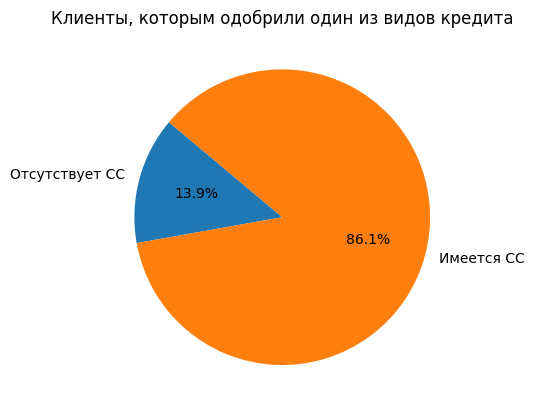

In [86]:
a = []
a.append(100 * len(df[(df['cc_flg'] == 0) & (df['agreement_product_code'] != 'Unsuccess')]) / len(df[(df['agreement_product_code'] != 'Unsuccess')]))
a.append(100 * len(df[(df['cc_flg'] == 1) & (df['agreement_product_code'] != 'Unsuccess')]) / len(df[(df['agreement_product_code'] != 'Unsuccess')]))
a = np.array(a)
plt.pie(a / 100, labels=['Отсутствует CC', 'Имеется CC'], autopct='%1.1f%%', startangle=140)
plt.title('Клиенты, которым одобрили один из видов кредита')

Text(0.5, 1.0, 'Клиенты, которым подошел вариант CLC')

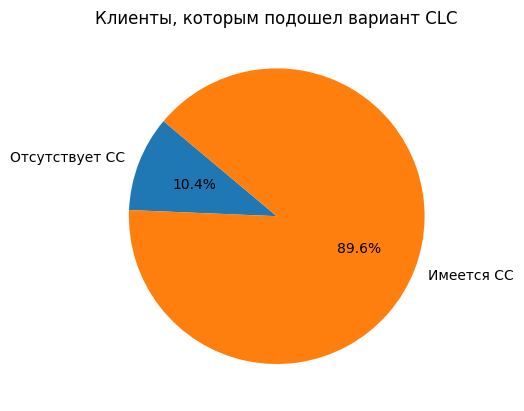

In [87]:
# На примере получивших одобрение кредита под залог автомобиля (CLC)
# анализируем долю обладателей кредитных карт
a = []
a.append(100 * df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) & (df['cc_flg'] == 0)].shape[0] /
         df[(df['agreement_product_code'] == 'CLC')].shape[0])
a.append(100 * df[((df['agreement_product_code'] == 'CLC') | (df['agreement_product_code'] == 'To CLC')) & (df['cc_flg'] == 1)].shape[0] /
         df[(df['agreement_product_code'] == 'CLC')].shape[0])
a = np.array(a)
plt.pie(a / 100, labels=['Отсутствует CC', 'Имеется CC'], autopct='%1.1f%%', startangle=140)
plt.title('Клиенты, которым подошел вариант CLC')

Text(0.5, 1.0, 'Клиенты, которым подошел вариант CLR')

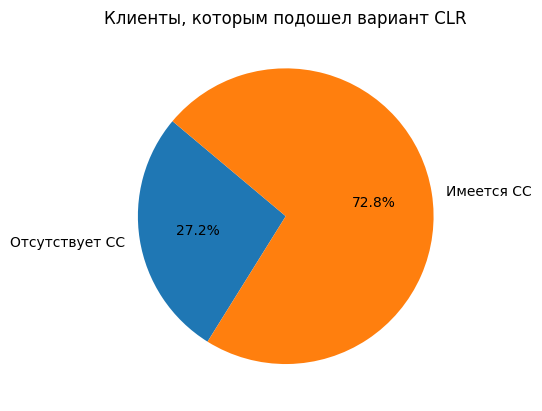

In [88]:
# На примере получивших одобрение кредита под залог недвижимости (CLR)
# анализируем долю обладателей кредитных карт
a = []
a.append(100 * df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) & (df['cc_flg'] == 0)].shape[0] /
         df[(df['agreement_product_code'] == 'CLC')].shape[0])
a.append(100 * df[((df['agreement_product_code'] == 'CLR') | (df['agreement_product_code'] == 'To CLR')) & (df['cc_flg'] == 1)].shape[0] /
         df[(df['agreement_product_code'] == 'CLC')].shape[0])
a = np.array(a)
plt.pie(a / 100, labels=['Отсутствует CC', 'Имеется CC'], autopct='%1.1f%%', startangle=140)
plt.title('Клиенты, которым подошел вариант CLR')